### 动手实现自己的第一个神经网络

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

In [2]:
# 准备数据
def load_data():
    # 训练样本有 300 个，测试样本有 100 个
    train_X, train_Y = make_circles(n_samples=300, noise=.05)
    test_X, test_Y = make_circles(n_samples=100, noise=.05)
    # 可视化数据
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    test_X = test_X.T
    test_Y = test_Y.reshape((1, test_Y.shape[0]))
    return train_X, train_Y, test_X, test_Y

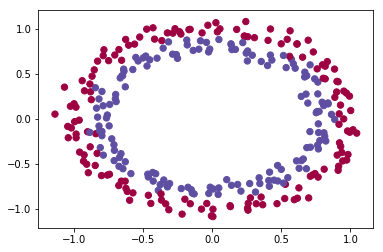

In [18]:
train_X, train_Y, test_X, test_Y = load_data()

### 构建一个简单的神经网络

![image.png](img/1.png)

1. 这个神经网络非常的简单，一层输入，两个隐藏层，最后一层输出层
2. 两个隐藏层分别用的是Relu的激活函数，最后输出层用的是sigmoid函数
3. 最后一个$\hat y$是一个输出，是一个0/1分类,还记得我们在逻辑回归中二分类问题用sigmoid吗

### 首先来看一下几个激活函数
$$ 
\begin{array}{l}{\text { sigmoid }(z)=\frac{1}{1+e^{-z}}} \\ {\tanh (z)=\frac{e^{z}-e^{-z}}{e^{z}+e^{-z}}} \\ {r e l u(z)=\max (z, 0)}\end{array}
 $$



In [4]:
def sigmoid(z):
    return 1. / (1 + np.exp(-z))

def tanh(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

def relu(z):
    return (np.abs(z) + z) / 2

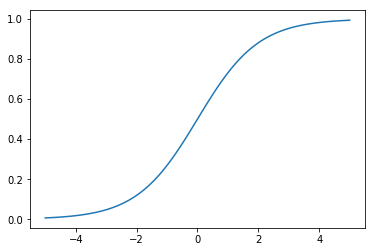

In [5]:
x = np.linspace(-5, 5, 100)
y = sigmoid(x)
plt.plot(x, y)
plt.show()

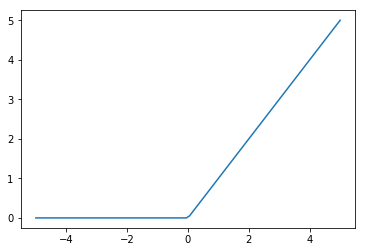

In [6]:
y = relu(x)
plt.plot(x, y)
plt.show()

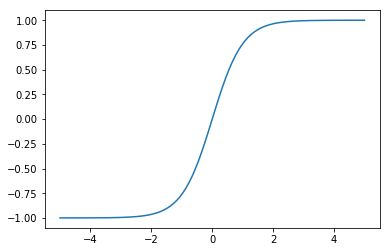

In [7]:
y = tanh(x)
plt.plot(x, y)
plt.show()

再看一下sigmoid函数的导函数
$$ 
s^{\prime}(x)=s(x) \cdot(1-s(x))
 $$
 
 RELU函数的导函数
 
$$ 
r e l u^{\prime}(z)=\left\{\begin{array}{lc}1&relu(z)>0\\0&relu(z)=0\end{array}\right.
$$
 
 有兴趣的自己可以尝试推导一下，非常简单的

### 我们现在来看前向传播过程
首先对于每一组数据来说，都有一个输入：$\left[ \begin{array}{l}{x_{1}} \\ {x_{2}}\end{array}\right]_{(2,1)}$

然后第一个隐藏层我们称之为$H_1$，其hidden_size为20，将还没有经过激活函数RELU的，称之为$Z_1$，那么我们马上有：
$$ 
Z_{1}=W_1X+b_{1}
 $$
 $$
 H_{1}=RELU(Z_1)
 $$
 
 其中$W_1$是从输入层到第一个隐藏层的参数，$b_1$是其bias项，如果对单个神经网络不熟悉的可以参考下图
 ![title](img/2.png)
 在这里面我们要十分的注意维度的变换，$W_1$的维度是(20,2)，$b_1$为(20,1),自然$Z_1$是(20,1),同样的$H_1$也是(20,1),他的过程大致是：
 $$ 
Z^{[1]}=W X+b^{[1]}=\left[ \begin{array}{cc}{w_{1,1}^{[1]}} & {w_{1,2}^{[1]}} \\ {w_{2,1}^{[1]}} & {w_{2,2}^{[1]}} \\ {\vdots} & {\vdots} \\ {w_{20,1}^{[1]}} & {w_{20,2}^{[1]}}\end{array}\right]_{(20,2)} \times \left[ \begin{array}{l}{x_{1}} \\ {x_{2}}\end{array}\right]_{(2,1)}+\left[ \begin{array}{c}{b_{1}^{[1]}} \\ {b_{2}^{[1]}} \\ {\vdots} \\ {b_{20}^{[1]}}\end{array}\right]_{(20,1)}
 $$


 当然对于第二个隐藏层，它的hidden_size是5，那么它的前向传播的一系列东西如下：
 $$Z_2=W_2H_1+b_2$$
 $$
 H_{2}=RELU(Z_2)
 $$
 
 其各个维度对应如下：$H_1$:(20,1)，$W_2$:(5,20)，$b_2$:(5,1)，$Z_2$:(5,1)，$H_2$:(5,1)
 

到了我们的最后一层，
$$Z_3=W_3H_2+b_3$$
$$\hat y = sigmoid(Z_3)$$
其各个维度对应如下：$H_2$:(5,1),$W_3$:(1,5),$b_3$:(1,)$H_3$:(1,)

然后最终得出来一个标量值，这个值根据我们设定的阈值，比如如果大于0.5，我们把它归为1，反之为0，就完成了我们的分类，也代表我们整个前向传播的过程结束了

### 我们来看看我们前向传播代码部分的实现

In [8]:
def initialize_parameters(layer_dims):
    ## 初始化权重和偏置项
    Weight = {}
    bias = {}
    for d in range(1, len(layer_dims)):
        Weight['W'+str(d)] = np.random.randn(layer_dims[d],layer_dims[d-1]) / np.sqrt(layer_dims[d-1])
        bias['b'+str(d)] = np.zeros((layer_dims[d],1))

    return Weight, bias

In [9]:
# 设定每一层的hidden_size
layer_dims = [2, 20, 5, 1]
W, b = initialize_parameters(layer_dims)
W['W3'].shape

(1, 5)

In [10]:
def forward_propagation(X, Weight, bias, activation):
    ## 前向传播函数
    Z = {}
    H = {}
    ## 一般把输入 X 看做第 0 层的输出 H0
    H['H0'] = X
    L = len(Weight)
    for l in range(1, L + 1):
        Z['Z' + str(l)] = np.dot(Weight['W' + str(l)], H['H'+str(l-1)]) + bias['b'+str(l)]
        exec("H['H' + str(l)] = " + activation[l-1] + "(Z['Z' + str(l)])")

    return H, Z

### 前向传播结束了我们来看看损失函数
在这边我们选用的是交叉熵损失函数（cross entropy，CE），想必经过百面优化那一章的学习，大家对一些常见的损失函数有一些认识了。
对于某一个样本来说，交叉熵损失函数如下
$$L\left(\hat{y}^{(i)}, y^{(i)}\right)=-\left(y^{(i)} \log \left(\hat{y}^{(i)}\right)+\left(1-y^{(i)}\right) \log \left(1-\hat{y}^{(i)}\right)\right)$$
那么对于整个样本来说，我们的损失函数可以这么定义：
$$J(w,b)=\frac{1}{m}\sum_ {i=1}^{m}L(\hat{y}^{(i)},y^{(i)})=-\frac{1}{m}\sum_ {i=1}^{m}[y^{(i)}log(\hat{y}^{(i)})+(1-y^{(i)})log(1-\hat{y}^{(i)})]+\frac{\lambda}{2m}||w||^2_{F}
$$
大家应该能注意到，我们在损失函数的最后加了一个L2正则式，进行一个权重的衰减，防止过拟合


In [11]:
def compute_cost(H, Y, Weight, lambd=0.7):
    m = Y.shape[1]
    L2_term = 0
    for key in Weight.keys():
        L2_term += (np.sum(np.square(Weight[key])))

    logprobs = np.multiply(-np.log(H['H'+str(len(H)-1)]) ,Y) + np.multiply(-np.log(1 - H['H'+str(len(H)-1)]), 1 - Y)
    ## 在训练的时候我们是一批数据进行迭代，最后取其总和的平均值
    cost = 1./ m * np.nansum(logprobs)
    cost += L2_term * lambd / (2 * m)
    return cost

### 接下来是反向传播的部分
首先是为什么要进行反向传播，是为了防止路径的重复计算。
我们再看看我们的网络图:
![image.png](img/1.png)


为了方便观看，我们把之前整个的一个前向传播的过程复制过来：
$$ 
Z_{1}=W_1X+b_{1}
 $$
 $$
 H_{1}=RELU(Z_1)
 $$
  $$Z_2=W_2H_1+b_2$$
 $$
 H_{2}=RELU(Z_2)
 $$
 $$Z_3=W_3H_2+b_3$$
$$\hat y = sigmoid(Z_3)$$

同时，把损失函数也弄过来：
$$J(w,b)=\frac{1}{m}\sum_ {i=1}^{m}L(\hat{y}^{(i)},y^{(i)})=-\frac{1}{m}\sum_ {i=1}^{m}[y^{(i)}log(\hat{y}^{(i)})+(1-y^{(i)})log(1-\hat{y}^{(i)})]+\frac{\lambda}{2m}||w||^2_{F}
$$

**注意，下面有的式子，为了直观没有写出来对矩阵求导的转置，写代码的时候需要注意这一点**

首先第一件事是对$z_3$进行求导
$$\frac{\partial J}{\partial z_3}=\frac{\partial J}{\partial \hat y}\frac{\partial \hat y}{\partial z_3}=\widehat y - y=\delta_3$$
为什么求这个式子，当然是为了链式相乘了，然后我们开始对参数w和b进行求导：

$$\frac{\partial J}{\partial w_3}=\frac{\partial J}{\partial z_3}\frac{\partial z_3}{\partial w_3}=\delta_3 H_2 + \frac1m \lambda w_3
$$
$$\frac{\partial J}{\partial b_3}=\frac{\partial J}{\partial z_3}\frac{\partial z_3}{\partial b_3}=\delta_3
$$

到这里我们完成了对w3和b3这两个参数进行求导，后面的基本上类似，就是运用链式求导的法则一层层往前求即可，我们我们继续向下写。
$$\frac{\partial J}{\partial z_2}=\frac{\partial J}{\partial z_3}\frac{\partial z_3}{\partial H_2}\frac{\partial H_2}{\partial z_2}=\delta_3 w_3 relu'(z_2)=\delta_2$$
$$\frac{\partial J}{\partial w_2}=\frac{\partial J}{\partial z_2}\frac{\partial z_2}{\partial w_2}=\delta_2 H_1 + \frac1m \lambda w_2 $$
$$\frac{\partial J}{\partial b_2}=\frac{\partial J}{\partial z_2}\frac{\partial z_2}{\partial b_2}=\delta_2 $$

对于w1和b1也是一样的
$$\frac{\partial J}{\partial z_1}=\frac{\partial J}{\partial z_2}\frac{\partial z_2}{\partial H_1}\frac{\partial H_1}{\partial z_1}=\delta_2 w_2 relu'(z_1)=\delta_1$$
$$\frac{\partial J}{\partial w_1}=\frac{\partial J}{\partial z_1}\frac{\partial z_1}{\partial w_1}=\delta_1 x + \frac1m \lambda w_1 $$
$$\frac{\partial J}{\partial b_1}=\frac{\partial J}{\partial z_1}\frac{\partial z_1}{\partial b_1}=\delta_1 $$

ok 我们完成了所有的反向求导，接下来我们终于可以愉快的写代码了！

### 在这里我们稍微的讲解一下一个小技巧
如果现在我不太懂矩阵求导，那么怎么办，我还能有办法把公式写对吗？在这里实际上是有一个小技巧的！
- 首先注意一点，一个标量对一个矩阵求导，其维度不变
$$\frac{\partial J}{\partial w_3}=\frac{\partial J}{\partial z_3}\frac{\partial z_3}{\partial w_3}=\delta_3 H_2
$$
那么通过前向传播的过程，我们发现，w3维度是(1,5)，z3维度是(1,1)
所以$\frac{\partial J}{\partial w_3}$维度是(1,5)
$\frac{\partial J}{\partial z_3}$维度是(1,1)
那么也就是说我们后面的求导$\frac{\partial z_3}{\partial w_3}$维度应当是(1,5)才行，我们发现H2的维度是(5,1)，所以我们知道了这里应该写成$H_2^T$


In [12]:
def backward_propagation(X, Y, Weight, bias, H, activation):
    m = X.shape[1]
    gradients = {}
    L = len(Weight)
    ## 计算导数
    gradients['dZ' + str(L)] = H['H' + str(L)] - Y
    gradients['dW' + str(L)] = 1./m * np.dot(gradients['dZ' + str(L)], H['H' + str(L-1)].T) + 1./m * lambd * Weight['W' + str(L)]
    gradients['db' + str(L)] = 1./m * np.sum(gradients['dZ' + str(L)], axis=1, keepdims = True)
    for l in range(L-1, 0, -1):
        gradients['dH' + str(l)] = np.dot(Weight['W'+str(l+1)].T, gradients['dZ'+str(l+1)])
        if activation[l-1] == 'relu':
            gradients['dZ'+str(l)] = np.multiply(gradients['dH'+str(l)], np.int64(H['H'+str(l)] > 0))
        elif activation[l-1] == 'tanh':
            gradients['dZ'+str(l)] = np.multiply(gradients['dH'+str(l)], 1 - np.power(H['H'+str(1)], 2))

        gradients['dW'+str(l)] = 1./m * np.dot(gradients['dZ'+str(l)], H['H'+str(l-1)].T) + 1./m * lambd * Weight['W' + str(l)]
        gradients['db'+str(l)] = 1./m * np.sum(gradients['dZ'+str(l)], axis=1, keepdims=True)

    return gradients

In [13]:
def updata_parameters(Weight, bias, gradients, lr = 0.1):
    ## 更新参数，lr 为 learning rate，是代表参数的学习率
    ## 太小会使网络收敛很慢，太大可能会使网络在最低点附近徘徊而不会收敛
    for i in range(1, len(Weight)+1):
        Weight['W'+str(i)] -= lr * gradients['dW'+str(i)]
        bias['b'+str(i)] -= lr * gradients['db'+str(i)]

    return Weight, bias

### 所有的部分我们都理清楚了，现在开始我们来训练

In [14]:
def nn_train(X,Y, Weight, bias, activation, lr=0.1, lambd=0.7, num_iterations=5000, print_cost=[True, 10000]):
    ## num_iteration 是迭代的次数，print_cost，可以在每几次迭代后打印成本。
    ## 每次迭代都会按「前向传播，计算成本，计算梯度，更新梯度」的顺序执行 
    for i in range(num_iterations):
        H, Z = forward_propagation(X, Weight, bias, activation)
        cost = compute_cost(H, Y, Weight, lambd)
        grads = backward_propagation(X, Y, Weight, bias, H, activation)
        Weight, b  = updata_parameters(Weight, bias, grads, lr)

        if print_cost[0] and i % print_cost[1] == 0:
            print("Cost after iteration %i: %f" % (i, cost))

    return Weight, bias

### 写好了训练的函数，我们来构造测试的函数

In [15]:
def cls_predict(X, Weight, bias, activation):
    ## 输出大于 0.5 的视为 1
    H, Z = forward_propagation(X, Weight, bias, activation)
    prediction = (H['H'+str(len(H)-1)] > 0.5)

    return prediction

def plot(model, X, y):
    ## 把预测结果可视化
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=np.squeeze(y), cmap=plt.cm.Spectral)
    plt.show()

Cost after iteration 0: 0.733948
Cost after iteration 10000: 0.159461
Cost after iteration 20000: 0.155739
0.99


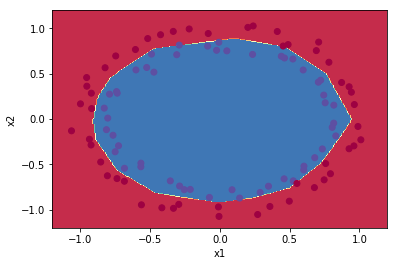

In [16]:
## 加载数据
train_X, train_Y, test_X, test_Y = load_data()

## 写定每一层的单元数和激活函数，注意：第一层是输入层，没有激活函数
## 可以试试自己改下每一层的单元数和激活函数看看对于预测结果的影响
layer_dims = [2, 20, 5, 1]
activation = ['relu', 'relu', 'sigmoid']
## 初始化参数
Weight, bias = initialize_parameters(layer_dims)
lambd = 0.7

## 开始训练，可以试着改变 lr 和 lambd 看看会有什么影响
nn_train(train_X, train_Y, Weight, bias, activation, lr=0.1, lambd=lambd, num_iterations=30000)

predictions = cls_predict(test_X, Weight, bias, activation)

accuracy = np.mean((predictions[0,:] == test_Y[0,:]))
print(accuracy)

axes = plt.gca()
axes.set_xlim([-1.20,1.20])
axes.set_ylim([-1.20,1.20])
plot(lambda x: cls_predict(x.T, Weight, bias, activation), test_X, test_Y)